In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Date 

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
#results = session.query(func.max(Measurement.date)).scalar()
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(recent_date)

2017-08-23


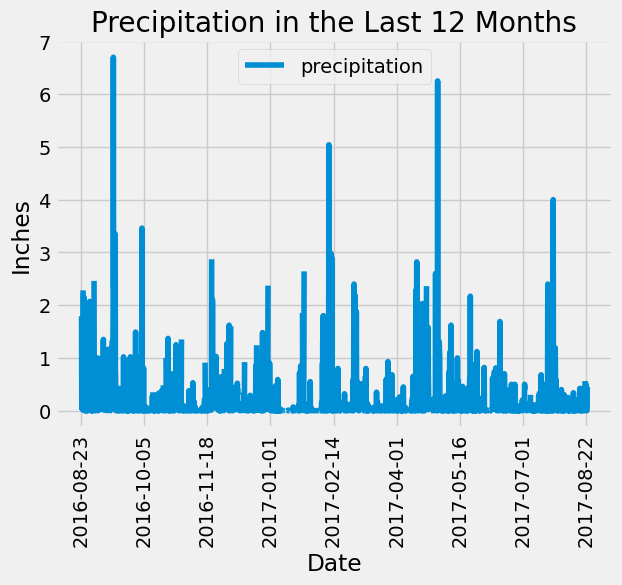

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

one_year_ago = dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

precipitation = session.query(Measurement.date,Measurement.prcp).\
         filter(Measurement.date.between(one_year_ago, recent_date)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(precipitation,columns = ['date', 'precipitation'])
df.set_index("date", inplace = True)
df.tail()
# Sort the dataframe by date
df.sort_values(by='date',inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.title("Precipitation in the Last 12 Months")
xtick_positions = range(0, len(df), len(df) // 8)
xtick_labels = df.index[xtick_positions]
plt.xticks(xtick_positions, xtick_labels, rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
print(one_year_ago)

2016-08-23


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(Station).count()
print(total_stations)

9


In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()

for station, count in active_stations:
    print(f"{station}: {count}")

USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [ ]:

most_active = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .first()

print(most_active)

('USC00519281', 2772)


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_id = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .first()[0]

result = session.query(
                func.min(Measurement.tobs)
                , func.max(Measurement.tobs)
                , func.avg(Measurement.tobs)).filter(Measurement.station == most_active_id).first()

print(result)


(54.0, 85.0, 71.66378066378067)


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.date, Measurement.tobs, Measurement.station).\
         filter(Measurement.date.between(one_year_ago, recent_date)).\
         filter(Measurement.station == most_active_id).all()

df = pd.DataFrame(results,columns = ['Date', 'TOBs', 'Station_ID'])
df.set_index('Station_ID', inplace=True)
df.head()


,Date,TOBs
Station_ID,,
USC00519281,2016-08-23,77.0
USC00519281,2016-08-24,77.0
USC00519281,2016-08-25,80.0
USC00519281,2016-08-26,80.0
USC00519281,2016-08-27,75.0


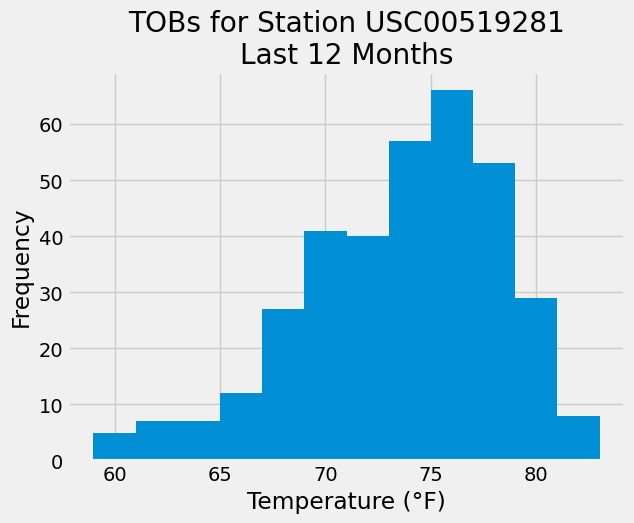

In [ ]:
temps = [result[1] for result in results]

# Create a histogram with 12 bins
plt.hist(temps, bins=12)

# Add axis labels and a title
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title("TOBs for Station " + most_active_id + "\nLast 12 Months")

# Show the plot
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()